# Agency-Grain Census Data -NTD Summary Table
- Purpose: To define and quantify the service population of each Cal-ITP partner transit agency using census, related demographic data and ridership data.
- Goal: Provide agency-level summaries that describe the characteristics of populations served, such as size, demographics, income, and travel behavior, to illustrate the reach and impact of Cal-ITP services.
- Use: Support data-driven storytelling and performance reporting by supplying key statistics for communications about the benefits, adoption, and equity potential of Cal-ITP initiatives (e.g., open-loop payment systems).

Steps:
- Fetching Agency Level [ACS data](https://console.cloud.google/storage/browser/_details/calitp-analytics-data/data-analyses/transit_provider_dashboard/agency_level_census_geodata.parquet;tab=live_object?csesidx=785603937&project=cal-itp-data-infra)
- Querying Annual Ridership Data from Warehouse 
- Merging Agency Level ACS data and Ridership Data on NTD ID

[Final Data Table](https://console.cloud.google/storage/browser/_details/calitp-analytics-data/data-analyses/transit_provider_dashboard/agency_acs_ntd_final.parquet;tab=live_object?csesidx=785603937&project=cal-itp-data-infra)


In [1]:
pip install shared_utils

Note: you may need to restart the kernel to use updated packages.


In [2]:
import shared_utils
import pandas as pd
import geopandas as gpd
import re
import google.auth
import os
import gcsfs
import fsspec


from calitp_data_analysis import get_fs
from calitp_data_analysis import geography_utils, utils
from calitp_data_analysis.sql import get_engine
credentials, project = google.auth.default()
from segment_speed_utils.project_vars import PUBLIC_GCS

fs = get_fs()
db_engine = get_engine()
pd.set_option("display.max_columns", None)

In [3]:
GCS_FILE_PATH  = 'gs://calitp-analytics-data/data-analyses/transit_provider_dashboard/'

In [4]:
# Querying NTD Ridership data 
with db_engine.connect() as connection:
    query = """
        SELECT
            agency, ntd_id, reporter_type, report_year, primary_uza_name, unlinked_passenger_trips_upt, agency_voms
        FROM 
            cal-itp-data-infra.mart_ntd.dim_annual_service_agencies
        WHERE 
            state = 'CA' AND report_year = 2023
    """
    ridership_data= pd.read_sql(query, connection)

In [5]:
# Grouping ridership data for each agency/ntd_id
ridership_data_grouped = ridership_data.groupby(
        [
            "agency",
            "ntd_id",           
        ]
    ).agg({
        "unlinked_passenger_trips_upt":"sum",
        "agency_voms":"sum"
    }).sort_values(by="ntd_id").reset_index()

In [6]:
ridership_data_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   agency                        209 non-null    object 
 1   ntd_id                        209 non-null    object 
 2   unlinked_passenger_trips_upt  209 non-null    float64
 3   agency_voms                   209 non-null    float64
dtypes: float64(2), object(2)
memory usage: 6.7+ KB


In [7]:
ridership_data_grouped.head(5)

,agency,ntd_id,unlinked_passenger_trips_upt,agency_voms
0,"San Francisco Bay Area Rapid Transit District,...",90003,50764402.0,582.0
1,Golden Empire Transit District,90004,3293593.0,89.0
2,Santa Cruz Metropolitan Transit District,90006,3350026.0,93.0
3,"City of Santa Monica, dba: Big Blue Bus",90008,7767725.0,143.0
4,"San Mateo County Transit District, dba: SamTrans",90009,8773845.0,331.0


In [8]:
# Function to get geodataframe from GCS
def read_parquet_from_gcs(filename):
    gcs_path = GCS_FILE_PATH.replace("gs://", "") + filename
    with fs.open(gcs_path, 'rb') as f:
        return gpd.read_parquet(f)

In [9]:
agency_acs = read_parquet_from_gcs("agency_level_census_geodata.parquet")

In [10]:
print(agency_acs.crs)

None


In [11]:
agency_acs = agency_acs.to_crs(epsg=4326)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

In [ ]:
import geopandas as gpd

agency_acs.explore(
    column="poverty_pop_adj",       # color by a column
    tooltip=["name", "total_pop_adj"],
    tiles="CartoDB positron",
    zoom_start=6
)


In [ ]:
# Drop rows with no values for ntd_id_2022
agency_acs = agency_acs.dropna(subset=['ntd_id_2022'])

In [ ]:
agency_acs.info()

In [ ]:
# Merge acs and ntd data 
merged_agency_ntd = (
    pd.merge(
        agency_acs,
        ridership_data_grouped,
        how='left',
        left_on='ntd_id_2022',
        right_on='ntd_id'
    )
    .sort_values(by='agency')
)


In [ ]:
merged_agency_ntd = gpd.GeoDataFrame(merged_agency_ntd, geometry='geometry', crs=agency_acs.crs)

In [13]:
merged_agency_ntd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 77 entries, 34 to 47
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   key                           77 non-null     object  
 1   name                          77 non-null     object  
 2   total_pop_adj                 77 non-null     float64 
 3   poverty_pop_adj               77 non-null     float64 
 4   non_us_citizen_adj            77 non-null     float64 
 5   workers_with_no_car_adj       77 non-null     float64 
 6   households_with_no_cars_adj   77 non-null     float64 
 7   disabled_pop_adj              77 non-null     float64 
 8   public_asst_pop_adj           77 non-null     float64 
 9   inc_extremelylow_adj          77 non-null     float64 
 10  inc_verylow_adj               77 non-null     float64 
 11  inc_low_adj                   77 non-null     float64 
 12  male_seniors_adj              77 non-null  

In [14]:
merged_agency_ntd.head(5)

,key,name,total_pop_adj,poverty_pop_adj,non_us_citizen_adj,workers_with_no_car_adj,households_with_no_cars_adj,disabled_pop_adj,public_asst_pop_adj,inc_extremelylow_adj,inc_verylow_adj,inc_low_adj,male_seniors_adj,female_seniors_adj,veteran_pop_adj,organization_type,ntd_id_x,ntd_id_2022,ntd_agency_info_key,schedule_gtfs_dataset_key,feed_key,geometry,agency,ntd_id_y,unlinked_passenger_trips_upt,agency_voms
34,71b58e792726688aef31d4712480d350,Amador Regional Transit System,3360.197100,253.010131,49.643708,32.478189,71.557429,3303.321705,1441.524068,829.809323,771.150660,438.065535,452.676047,581.792441,351.080526,Independent Agency,9R02-91000,91000,recyQ9Dp6JKnr3Lmr,36b8fbf12e4adc76b21651462b200860,060d2411597ab95f9eab898be2c98b24,"MULTIPOLYGON (((-44038.307 52405.397, -44096.8...",Amador Transit,91000,32626.0,18.0
53,a49a3c2c1b56a748da002e3f343fa1c5,Anaheim Transportation Network,108056.009575,12472.426760,22143.250122,1437.491757,1653.340518,105972.504511,31401.812009,24013.184939,20804.849121,11421.468085,4316.174293,5881.569282,2038.609995,Independent Agency,90211,90211,rec6g6iKaKu4n4r89,499d04458c70d08d63fcc6ec763dca57,ee74c1e84dea98775e54776f2d3f3294,"POLYGON ((196529.890 -466559.720, 196451.778 -...","Anaheim Transportation Network, dba: Anaheim R...",90211,8289646.0,54.0
41,8ba736645cf9016bd129181068a9bc7b,Butte County Association of Governments,103333.535509,22155.621279,3372.409051,1148.402256,3042.470290,102406.452073,42325.463068,32349.832539,19035.566640,10496.294331,6969.522660,9758.600665,4835.699460,MPO/RTPA,90208,90208,rec7wacWpNhcSlyV3,68aa06a25a32c83eb38c20c43977feff,a42c96ce9df6597edaaea081a44f261a,"MULTIPOLYGON (((-135810.596 167958.409, -13583...","Butte County Association of Governments, dba: ...",90208,630109.0,37.0
40,84b7f666f6bc8400ca3f2b5f0976a084,City of Burbank,74520.512319,8626.912617,6208.449245,1062.461747,2935.882762,74222.271713,33703.626827,16021.924375,12994.661875,9255.102656,4287.042553,5637.801633,1633.348297,City/Town,90256,90256,recuKiKWswXEevRnm,22b1fd6db336c11d8df960e58cf79d73,21382c6e47ff71d90ab19498fc1bd5c1,"POLYGON ((152218.501 -422383.611, 152292.852 -...",City of Burbank,90256,171517.0,17.0
66,dd05df714d202127bb57b408f1b989f1,City of Calabasas,23519.068990,2108.517586,1694.507057,74.848875,195.274950,23434.756843,8962.061030,4119.742113,2815.074465,1337.064900,1974.431636,2210.082059,580.419279,City/Town,90257,90257,recpZafSF9wuQwXau,907a502754757f897cef1409d297a397,9e6a6a221742cc2fcbf2c2634823e394,"POLYGON ((120408.451 -426639.066, 120459.238 -...",City of Calabasas,90257,23743.0,8.0


In [18]:
merged_agency_ntd = merged_agency_ntd.set_crs(epsg=4326)

<Axes: >

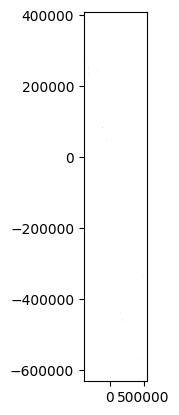

In [22]:
merged_agency_ntd.plot(column="name")

In [15]:
# Rows from agency_acs that didn't find a match
unmatched_agency_acs = agency_acs[
    ~agency_acs['ntd_id_2022'].isin(ridership_data_grouped['ntd_id'])
]


# Optionally view them
unmatched_agency_acs[['ntd_id_2022', 'name']]


,ntd_id_2022,name
21,90233,Yuma County Intergovernmental Public Transport...
50,90280,City of Lawndale


In [16]:
# Get all names from unmatched_agency_acs
names_to_check = unmatched_agency_acs['name'].unique()

# Filter ridership_data_grouped for exact matches
matches_in_ridership = ridership_data_grouped[ridership_data_grouped['agency'].isin(names_to_check)]

# View results
matches_in_ridership[['ntd_id', 'agency']]


,ntd_id,agency


In [18]:
# Function to export table as geodataframe 
def export_gdf(gdf, filename: str):
    
    gdf.to_parquet(f"{filename}.parquet")
    
    fs.put(
        f"{filename}.parquet",
        f"{GCS_FILE_PATH}{filename}.parquet",
        token = credentials.token
    )
    
    os.remove(f"{filename}.parquet")
    print(f"saved {GCS_FILE_PATH}{filename}.parquet")
    
    return

In [19]:
# Store data in warehouse
export_gdf(merged_agency_ntd, "agency_acs_ntd_final")

saved gs://calitp-analytics-data/data-analyses/transit_provider_dashboard/agency_acs_ntd_final.parquet


In [17]:
GCS__PUBLIC_FILE_PATH = f"{PUBLIC_GCS}"

def export_gdf_public(gdf, filename: str):
    geojson_str = gdf.to_json()

    with fsspec.open(f"{GCS__PUBLIC_FILE_PATH}/{filename}.geojson", 'w') as f_out:
        f_out.write(geojson_str)

    print(f"Saved to {GCS__PUBLIC_FILE_PATH}/{filename}.geojson")

In [21]:
export_gdf_public(merged_agency_ntd, "transitprovider_acs_ridership_data")

Saved to gs://calitp-publish-data-analysis//transitprovider_acs_ridership_data.geojson
